In [ ]:
#import sys
#!{sys.executable} -m pip install pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 5.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip3 install --upgrade pip


In [31]:
import csv
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt  
from ipywidgets import interact, FloatSlider
from datetime import datetime

import os

import numpy as np
from numpy.linalg import solve

import pandas as pd
from scipy.interpolate import BSpline


# Traitement de la série temporelle 

In [15]:
# Préparation des dataframes des séries temporelles
Data_file = "data/Data/S1A_ASC-DSC_VV-VH_Paracou"

df_VH_ASC_TropiScat = pd.read_csv(f"{Data_file}/s1a_vh_ASC_047_TropiScat.csv")
df_VH_DSC_TropiScat =  pd.read_csv(f"{Data_file}/s1a_vh_DSC_039_TropiScat.csv")
df_VV_ASC_TropiScat =  pd.read_csv(f"{Data_file}/s1a_vv_ASC_047_TropiScat.csv")
df_VV_DSC_TropiScat =  pd.read_csv(f"{Data_file}/s1a_vv_DSC_039_TropiScat.csv")

dfs_TropiScat = {
    "VV_ASC": df_VV_ASC_TropiScat,
    "VH_ASC": df_VH_ASC_TropiScat,
    "VV_DSC": df_VV_DSC_TropiScat,
    "VH_DSC": df_VH_DSC_TropiScat,
}
df_VH_ASC_allROI =  pd.read_csv(f"{Data_file}/s1a_vh_ASC_047_allROI.csv")
df_VH_DSC_allROI =  pd.read_csv(f"{Data_file}/s1a_vh_DSC_039_allROI.csv")
df_VV_ASC_allROI =  pd.read_csv(f"{Data_file}/s1a_vv_ASC_047_allROI.csv")
df_VV_DSC_allROI =  pd.read_csv(f"{Data_file}/s1a_vv_DSC_039_allROI.csv")

dfs_allROI = {
    "VV_ASC": df_VV_ASC_allROI,
    "VH_ASC": df_VH_ASC_allROI,
    "VV_DSC": df_VV_DSC_allROI,
    "VH_DSC": df_VH_DSC_allROI,
}


value_TropiScat= {
    "VV_ASC": df_VV_ASC_TropiScat.select_dtypes(include='number').to_numpy(),
    "VH_ASC": df_VH_ASC_TropiScat.select_dtypes(include='number').to_numpy(),
    "VV_DSC": df_VV_DSC_TropiScat.select_dtypes(include='number').to_numpy(),
    "VH_DSC": df_VH_DSC_TropiScat.select_dtypes(include='number').to_numpy(),
}

value_allROI = {
    "VV_ASC": df_VV_ASC_allROI.select_dtypes(include='number').to_numpy(),
    "VH_ASC": df_VH_ASC_allROI.select_dtypes(include='number').to_numpy(),
    "VV_DSC": df_VV_DSC_allROI.select_dtypes(include='number').to_numpy(),
    "VH_DSC": df_VH_DSC_allROI.select_dtypes(include='number').to_numpy(),
}

date_TropiScat= {
    "VV_ASC": np.array(df_VV_ASC_TropiScat)[:,0],
    "VH_ASC": np.array(df_VH_ASC_TropiScat)[:,0],
    "VV_DSC": np.array(df_VV_DSC_TropiScat)[:,0],
    "VH_DSC": np.array(df_VH_DSC_TropiScat)[:,0],
}
date_allROI= {
    "VV_ASC": np.array(df_VV_ASC_allROI)[:,0],
    "VH_ASC": np.array(df_VH_ASC_allROI)[:,0],
    "VV_DSC": np.array(df_VV_DSC_allROI)[:,0],
    "VH_DSC": np.array(df_VH_DSC_allROI)[:,0],
}

# Modèle théorique 

Formulation spline :

$$ s(t) = \sum_{j=1}^{K} \beta_j B_j(t) $$

- $B_j(t)$ → fonctions de base B-splines  

- $\beta_j$ → coefficients à estimer  

- $K$ → nombre de fonctions de base (dépend du nombre de nœuds)

Critère pénalisé :

$$ \hat{\beta} = \arg\min_{\beta} \left( \sum (Y - B\beta)^2 + \lambda \sum \beta_j^2 \right) $$


## Implémentation de la base B_Spline

On définit la matrice de base spline :

$$
B =
\begin{bmatrix}
B_1(t_1) & \dots & B_K(t_1) \\
\vdots & \ddots & \vdots \\
B_1(t_n) & \dots & B_K(t_n)
\end{bmatrix}
$$

Chaque ligne correspond à une observation temporelle $t_i$  
Chaque colonne correspond à une fonction de base $B_j(t)$  

In [20]:

def build_bspline_basis(t, n_knots, degree=3):
    knots_internal = np.linspace(t.min(), t.max(), n_knots)
    knots = np.concatenate(([t.min()] * degree,
                            knots_internal,
                            [t.max()] * degree))
    
    K = len(knots) - degree - 1
    B = np.zeros((len(t), K))
    
    for j in range(K):
        coeff = np.zeros(K)
        coeff[j] = 1
        spline_basis = BSpline(knots, coeff, degree)
        B[:, j] = spline_basis(t)
    
    return B

## Regression de la Spline Pénalisée

In [21]:
def penalized_spline_fit(B, Y, lam):
    beta = solve(B.T @ B + lam * np.eye(B.shape[1]), B.T @ Y)
    Y_hat = B @ beta
    return beta, Y_hat

## Matrice de Lissage

$$ S_\lambda = B(B^TB + \lambda I)^{-1}B^T $$

$$ EDF(\lambda) = \mathrm{trace}(S_\lambda) $$


In [22]:
def smoothing_matrix(B, lam):
    return B @ solve(B.T @ B + lam * np.eye(B.shape[1]), B.T)

def compute_edf(B, lam):
    return np.trace(smoothing_matrix(B, lam))

## Optimisation de λ via GCV 

$$ GCV(\lambda) = \frac{n \sum (Y - \hat{s}_\lambda)^2}{(n - EDF(\lambda))^2} $$


In [23]:
def gcv_score(B, Y, lam):
    n = len(Y)
    _, Y_hat = penalized_spline_fit(B, Y, lam)
    residual = np.sum((Y - Y_hat)**2)
    edf = compute_edf(B, lam)
    return (n * residual) / ((n - edf)**2)

def optimize_lambda_gcv(B, Y):
    lambdas = np.logspace(-4, 4, 100)
    scores = np.array([gcv_score(B, Y, lam) for lam in lambdas])
    return lambdas[np.argmin(scores)]

# Modélisation

## Zone régionale

In [24]:
# FONCTION PRINCIPALE MODÉLISATION RÉGIONALE
def regional_penalized_model(t, Y_reg,n, lam=None, auto_lambda=False):
    B = build_bspline_basis(t,n)
    
    if auto_lambda:
        lam = optimize_lambda_gcv(B, Y_reg)
        print("Lambda optimal (GCV) =", lam)
    elif lam is None:
        lam = 1.0
    
    beta, Y_hat = penalized_spline_fit(B, Y_reg, lam)
    EDF = compute_edf(B, lam)
    omega_c = lam**(-1/4)
    
    print("EDF =", EDF)
    print("Fréquence de coupure ω_c =", omega_c)
    
    return Y_hat, lam, EDF, omega_c

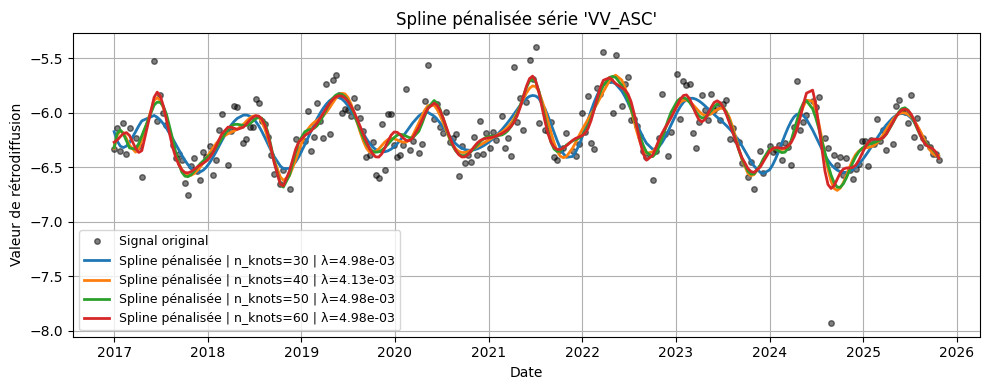

In [ ]:
# --- Paramètres du plot ---
knot_list = [30, 40, 50, 60]  # nombres de noeuds pour les splines
roi_index = 0                 
series_to_plot = "VV_ASC"     # VV_ASC ou VH_ASC 

# Régional/Local sot allROI ou Tropiscat

value_source = value_allROI
date_source  = date_allROI


# Préparer les données pour la série choisie
dates = date_source[series_to_plot]
values_array = value_source[series_to_plot]

# s'assurer que values_array est 2D
if values_array.ndim == 1:
    values_array = values_array[:, np.newaxis]

# ajuster roi_index si nécessaire
roi_idx = min(roi_index, values_array.shape[1]-1)
values = values_array[:, roi_idx]

# temps numérique pour les splines
t = np.arange(len(dates))
fs = 1  # fréquence fictive (optionnel)

# Affichage
dates = pd.to_datetime(dates)

# Temps numérique pour les splines
t_numeric = np.array([(d - dates[0]).days for d in dates])

plt.figure(figsize=(10, 4))  # figure plus compacte

# Signal original (points noirs semi-transparents)
plt.plot(dates, values, 'o', color='black', alpha=0.5, markersize=4, label="Signal original")

# Superposition des splines
for n_knots in knot_list:
    B = build_bspline_basis(t_numeric, n_knots)
    lam_opt = optimize_lambda_gcv(B, values)
    _, Y_hat = penalized_spline_fit(B, values, lam_opt)
    
    plt.plot(dates, Y_hat, linewidth=2, label=f"Spline pénalisée | n_knots={n_knots} | λ={lam_opt:.2e}")

# Titres et axes
plt.title(f"Spline pénalisée série '{series_to_plot}'", fontsize=12)
plt.xlabel("Date")
plt.ylabel("Valeur de rétrodiffusion")

# Légende simple
plt.legend(fontsize=9)

# Grille simple
plt.grid(True)

plt.tight_layout()
plt.show()
